In [7]:
%cd /content

! git clone https://github.com/RiboRings/AlzheimerPrediction.git

/content
Cloning into 'AlzheimerPrediction'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (12/12), 432.21 KiB | 16.01 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/AlzheimerPrediction


In [6]:
%cd /content/AlzheimerPrediction

/content


In [8]:
import numpy as np
import pandas as pd

df_cross = pd.read_csv("../alzheimer_data/oasis_cross-sectional.csv")
df_long = pd.read_csv("../alzheimer_data/oasis_longitudinal.csv")

# Preprocessing

In [9]:
# Rename cols to match names in df_cross
df_long = df_long.rename(columns={"MRI ID": "ID", "EDUC": "Educ", "MR Delay": "Delay"})

# Create columns for easy distinction between the cohorts
df_cross["Cohort"] = "OASIS1"
df_long["Cohort"] = "OASIS2"

# Concatenate df_cross with df_long
df = pd.concat([df_cross, df_long])

# Drop rows with missing target variable
df.dropna(subset=["CDR"], inplace=True)

# Remove cols with only one distinct value
df.drop(["Hand"], axis=1, inplace=True)

# Use ID as row index
df.index = df.pop("ID")

In [10]:
from sklearn.impute import SimpleImputer

# Given a uniform distribution, impute SES with mode
ses_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
# Given a skewed distribution, impute MMSE with median
mmse_imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# Fit imputer on SES
ses_imputer.fit(df[["SES"]])
# Impute missing values in SES
df["SES"] = ses_imputer.fit_transform(df[["SES"]])

# Fit imputer on MMSE
mmse_imputer.fit(df[["MMSE"]])
# Impute missing values in MMSE
df["MMSE"] = mmse_imputer.fit_transform(df[["MMSE"]])

In [11]:
from sklearn import preprocessing

# Create LabelEncoder
le = preprocessing.LabelEncoder()
# Encode original CDR from (0, 0.5, 1, 1.5, 2) to (0, 1, 2, 3)
df["CDR"] = le.fit_transform(df["CDR"])

# Preliminary Exploration

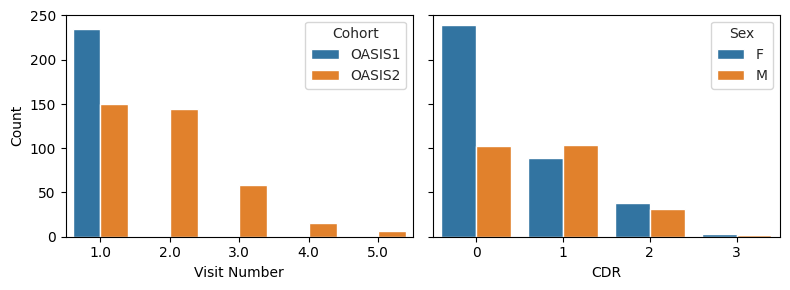

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

df["Visit"] = df["Visit"].fillna(value=1)

ncol = 2
fig, axes = plt.subplots(1, ncol, sharey=True)

fig.set_figheight(3)
fig.set_figwidth(8)
sns.set_style("ticks")

sns.countplot(df, x="Visit", hue="Cohort", ax=axes[0])
axes[0].set_xlabel("Visit Number")
axes[0].set_ylabel("Count")

sns.countplot(df, x="CDR", hue="M/F", ax=axes[1])
axes[1].set_ylabel("")
axes[1].legend(title="Sex")

plt.tight_layout()

In [13]:
grouped_df = df.groupby(["Visit", "CDR"]).size()
size_arr = df.groupby("Visit").size().values

count_df = pd.DataFrame({
    "Visit": [i[0] for i in grouped_df.index],
    "CDR": [i[1] for i in grouped_df.index],
    "Count": grouped_df.values
})

count_df["Percentage"] = count_df["Count"] / count_df["Visit"].map(lambda x: size_arr[round(x) - 1]) * 100

Text(0, 0.5, 'Relative Percentage (%)')

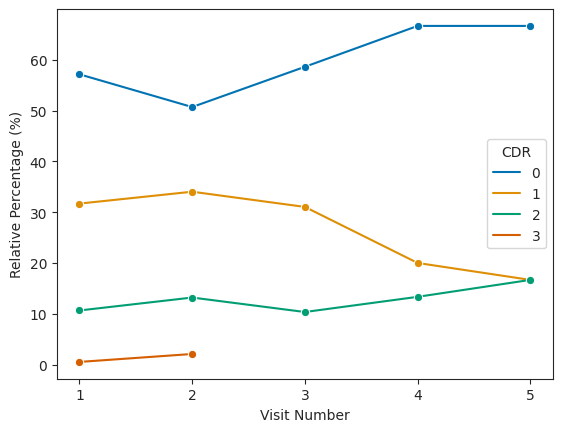

In [14]:
sns.lineplot(
    count_df, x="Visit", y="Percentage",
    hue="CDR", palette="colorblind",
    marker="o"
)

plt.xlabel("Visit Number")
plt.xticks(range(1, 6))

plt.ylabel("Relative Percentage (%)")

In [15]:
from sklearn import decomposition

X = df.drop(["CDR", "Delay", "Subject ID", "Group", "Visit", "M/F", "Cohort"], axis=1)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
red_dims = pca.transform(X)

In [16]:
def plot_pca(red_dims, hue, ax, palette="colorblind", s=15):

    sns.scatterplot(
    x=red_dims[:, 0], y=red_dims[:, 1],
    hue=hue, palette=palette,
    s=s, ax=ax
    )

ncol, nrow = 2, 2
my_palette = sns.color_palette("viridis", as_cmap=True)

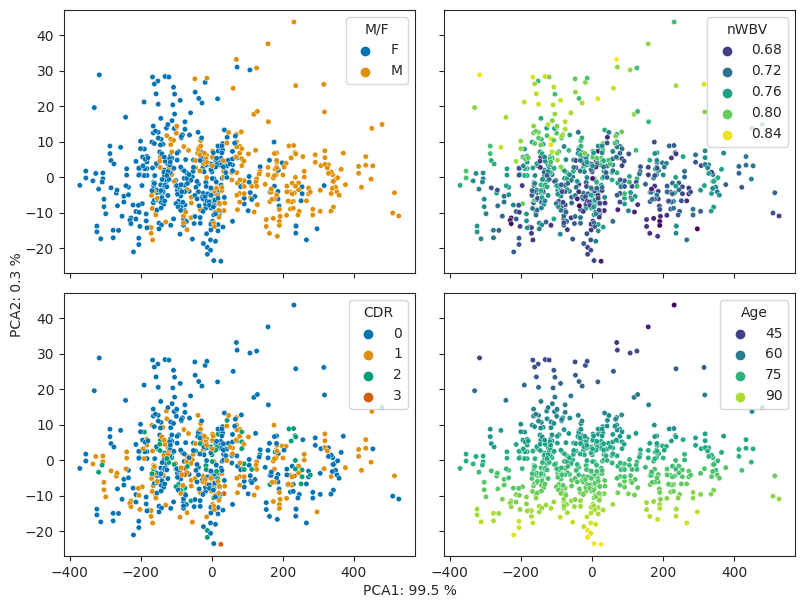

In [17]:
fig, axes = plt.subplots(ncol, nrow, sharex=True, sharey=True)

fig.set_figheight(3 * nrow)
fig.set_figwidth(8)
sns.set_style("ticks")

plot_pca(red_dims, df["M/F"], axes[0, 0])
plot_pca(red_dims, df["Age"], axes[1, 1], palette=my_palette)
plot_pca(red_dims, df["CDR"], axes[1, 0])
plot_pca(red_dims, df["nWBV"], axes[0, 1], palette=my_palette)

fig.text(0.5, 0, f"PCA1: {pca.explained_variance_ratio_[0] * 100:.1f} %", ha="center")
fig.text(0, 0.5, f"PCA2: {pca.explained_variance_ratio_[1] * 100:.1f} %", va="center", rotation="vertical")

plt.tight_layout()

In [ ]:
corr = X.corr()
sns.heatmap(
    corr, cmap="vlag", annot=True,
    fmt=".2f", annot_kws={'size': 10},
    vmin=-1, vmax=1
)

# Baseline Performance

_What is the minimal performance that we should expect from a model?_ This question can be answered by setting a **baseline performance**. This usually corresponds to the accuracy obtained with a very simple model, such as a classifier that predicts everything to be the most frequent class. The latter approach is applied here to estimate a baseline performance for the cross-sectional and longitudinal datasets as well as the combined dataset.

In [ ]:
# Split dataframe into features (X) and target (y)
def X_y_split(df, target="CDR", drop_cols=["CDR", "Delay", "Subject ID", "Group", "Visit", "Cohort"]):

    X = df.drop(drop_cols, axis=1)
    y = df.copy().pop(target)

    return X, y

# Split preprocessed datasets
df_cross = df.loc[df["Cohort"] == "OASIS1", ]
df_long = df.loc[df["Cohort"] == "OASIS2", ]

# Split X and y for combined dataset and separate datasets
X, y = X_y_split(df)
X_cross, y_cross = X_y_split(df_cross)
X_long, y_long = X_y_split(df_long)

In [ ]:
from sklearn.dummy import DummyClassifier

# Compute baseline performance based on given strategy
def baseline_performance(X, y, strategy="most_frequent"):

    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(X, y)
    dummy_clf.predict(X)

    return dummy_clf.score(X, y)

print(f"Baseline performance for all data: {baseline_performance(X, y) * 100:.2f}%")
print(f"Baseline performance for cross-sectional data: {baseline_performance(X_cross, y_cross) * 100:.2f}%")
print(f"Baseline performance for longitudinal data: {baseline_performance(X_long, y_long) * 100:.2f}%")